In [121]:
# Data handling and analysis libraries
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt
import ta
from pandas_datareader import data as pdr

# Statistical testing and diagnostics
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan, normal_ad
from scipy.stats import gaussian_kde

# Visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from prettytable import PrettyTable

# Machine learning preprocessing and evaluation
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit


# Machine learning algorithms
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.svm import SVR

# Deep learning libraries from Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session


# Miscellaneous utilities
import warnings
warnings.filterwarnings('ignore')

# Setting seed for reproducibility
np.random.seed(42)  # For numpy operations
import random
random.seed(42)  # For Python random library
import tensorflow as tf
tf.random.set_seed(42)  # For TensorFlow operations

FOR SELECTION OF STOCKS, REFER TO Stocks_Cluster. DO NOT RUN Stocks_Cluster AS IT TAKES VERY LONG

In [4]:
# Downloading the data from Yahoo Finance
start_date = '2012-01-01'
end_date = '2019-12-31'

#Correlation check with respect to all Mega Cap US Stocks.
symbols = ['AAPL', 'ABBV', 'AMZN', 'AVGO', 'BAC','GOOGL', 'HD', 'JNJ', 'JPM', 'META', 'NFLX', 'NVDA', 'ORCL', 'TSLA', 'UNH', 'WFC']
df_corr = yf.download(symbols,start_date,end_date)

[*********************100%%**********************]  16 of 16 completed


# Correlation Between Stocks

In [40]:
# Creating a DataFrame with only the Adj Close
df_returns_corr = df_corr['Adj Close'].copy()
df_returns_corr.head(5)

Ticker,AAPL,ABBV,AMZN,AVGO,BAC,GOOGL,HD,JNJ,JPM,META,NFLX,NVDA,ORCL,TSLA,UNH,WFC
Date,,,,,,,,,,,,,,,,
2012-01-03,12.433824,NaN,8.9515,21.081671,4.723225,16.651901,31.886053,46.611202,24.695110,NaN,10.320000,3.219730,21.522532,1.872000,42.696808,20.010784
2012-01-04,12.500644,NaN,8.8755,20.717564,4.731369,16.723724,32.340061,46.328190,24.851547,NaN,11.492857,3.256423,21.647379,1.847333,43.318722,20.102287
2012-01-05,12.639427,NaN,8.8805,20.746687,5.138544,16.491741,32.604885,46.271595,25.370621,NaN,11.328571,3.373379,22.130087,1.808000,43.608955,20.426065
2012-01-06,12.771558,NaN,9.1305,20.615614,5.032680,16.266768,32.688133,45.868309,25.143084,NaN,12.327143,3.334394,22.413063,1.794000,43.766499,20.369747
2012-01-09,12.751301,NaN,8.9280,22.006491,5.105970,15.577077,32.710827,45.939053,25.100410,NaN,14.025714,3.334394,22.546524,1.816667,43.716740,20.623144


In [41]:
corr_matrix = df_returns_corr.corr(method='pearson')

# Visualise the correlation matrix using a heatmap
corr_stocks_fig = go.Figure(data=go.Heatmap(
  z=corr_matrix.values,
  x=corr_matrix.columns,
  y=corr_matrix.index,
  colorscale='Blues',
  colorbar=dict(title='Coefficients'),
))

corr_stocks_fig.update_layout(
  title='Correlation absolutes between Stocks',
  width=800,
  height=500,
)

corr_stocks_fig.show()

corr_mean = []

print('\n')
# Finding the stock that has the highest mean correlation with other stocks
for n in corr_matrix:
    corr_mean.append({'stock':n,'cor':corr_matrix[n].mean()})
cor=pd.DataFrame(corr_mean)
print(cor.sort_values(by=['cor'],ascending=False))



    stock       cor
5   GOOGL  0.935853
8     JPM  0.935377
14    UNH  0.933513
6      HD  0.929772
4     BAC  0.924808
3    AVGO  0.922108
9    META  0.920042
7     JNJ  0.916900
2    AMZN  0.902407
0    AAPL  0.900329
12   ORCL  0.900102
10   NFLX  0.898082
1    ABBV  0.883786
11   NVDA  0.883075
13   TSLA  0.801993
15    WFC  0.798265


In [42]:
df = yf.download(symbols, group_by='Ticker', start=start_date, end=end_date)

[*********************100%%**********************]  16 of 16 completed


In [43]:
df.to_csv('stocks_final.csv')

In [44]:
df=pd.read_csv('stocks_final.csv',header=[0, 1], index_col=[0])

In [45]:
DF = df.stack(level=0).rename_axis(['Date', 'symbols']).reset_index(level=1)

In [46]:
DF.reset_index(inplace=True)

In [47]:
DF['Date'] = pd.to_datetime(DF['Date'])

In [48]:
DF['Date'].dtypes

dtype('<M8[ns]')

In [49]:
DF.columns.name = None

In [50]:
DF.tail(16)

,Date,symbols,Adj Close,Close,High,Low,Open,Volume
31815,2019-12-30,AAPL,70.911537,72.879997,73.172501,71.305000,72.364998,144114400.0
31816,2019-12-30,ABBV,72.665588,88.519997,89.730003,88.160004,89.220001,7014800.0
31817,2019-12-30,AMZN,92.344498,92.344498,94.199997,92.030998,93.699997,73494000.0
31818,2019-12-30,AVGO,274.605499,313.459991,317.329987,312.750000,316.519989,1310400.0
31819,2019-12-30,BAC,31.607437,35.150002,35.650002,35.090000,35.570000,30705100.0
31820,2019-12-30,GOOGL,66.985497,66.985497,67.849998,66.891998,67.840500,19994000.0
31821,2019-12-30,HD,196.187988,217.309998,220.490005,216.550003,220.369995,3952400.0
31822,2019-12-30,JNJ,129.501953,145.300003,146.199997,145.029999,145.779999,2923300.0
31823,2019-12-30,JPM,121.379730,138.630005,140.080002,138.470001,139.899994,6963000.0
31824,2019-12-30,META,204.193344,204.410004,207.899994,203.899994,207.860001,10524300.0


In [51]:
ticker_counts = DF['symbols'].value_counts()

# Print the counts of each ticker
print(ticker_counts)

symbols
AAPL     2011
AMZN     2011
AVGO     2011
BAC      2011
GOOGL    2011
HD       2011
JNJ      2011
JPM      2011
NFLX     2011
NVDA     2011
ORCL     2011
TSLA     2011
UNH      2011
WFC      2011
META     1916
ABBV     1761
Name: count, dtype: int64


In [52]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31831 entries, 0 to 31830
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       31831 non-null  datetime64[ns]
 1   symbols    31831 non-null  object        
 2   Adj Close  31831 non-null  float64       
 3   Close      31831 non-null  float64       
 4   High       31831 non-null  float64       
 5   Low        31831 non-null  float64       
 6   Open       31831 non-null  float64       
 7   Volume     31831 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 1.9+ MB


In [53]:
df_googl=DF[DF['symbols']=='GOOGL'].set_index('Date').reset_index()
df_jnj=DF[DF['symbols']=='JNJ'].set_index('Date').reset_index()
df_aapl=DF[DF['symbols']=='AAPL'].set_index('Date').reset_index()

# Exploratory Data Analysis

In [54]:
df_googl.describe()

,Date,Adj Close,Close,High,Low,Open,Volume
count,2011,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000,2.011000e+03
mean,2016-01-01 03:10:28.344107520,37.296257,37.296257,37.603698,36.968385,37.297414,5.337210e+07
min,2012-01-03 00:00:00,13.990240,13.990240,14.127127,13.926927,14.022523,1.041200e+07
25%,2014-01-02 12:00:00,26.152000,26.152000,26.538250,25.938750,26.217871,2.895700e+07
50%,2015-12-31 00:00:00,36.212502,36.212502,36.564499,35.783501,36.222000,3.963200e+07
75%,2017-12-28 12:00:00,51.903000,51.903000,52.560749,51.328749,51.998251,6.891701e+07
max,2019-12-30 00:00:00,68.123497,68.123497,68.352501,67.650002,68.199997,4.971983e+08
std,NaN,15.054050,15.054050,15.181187,14.916192,15.046616,3.946015e+07


In [55]:
df_jnj.describe()

,Date,Adj Close,Close,High,Low,Open,Volume
count,2011,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000,2.011000e+03
mean,2016-01-01 03:10:28.344107520,87.568591,108.075152,108.719398,107.370129,108.057046,8.098712e+06
min,2012-01-03 00:00:00,44.525757,61.779999,62.310001,61.709999,62.040001,2.353800e+06
25%,2014-01-02 12:00:00,70.053825,92.809998,93.389999,92.099998,92.795002,5.805000e+06
50%,2015-12-31 00:00:00,83.220322,106.470001,106.910004,105.519997,106.209999,7.368000e+06
75%,2017-12-28 12:00:00,110.646385,129.889999,130.904999,128.739998,129.899994,9.381150e+06
max,2019-12-30 00:00:00,130.518005,148.139999,148.990005,147.000000,147.839996,9.844020e+07
std,NaN,23.968817,23.544268,23.751731,23.353996,23.563024,4.193212e+06


In [56]:
df_aapl.describe()

,Date,Adj Close,Close,High,Low,Open,Volume
count,2011,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000,2.011000e+03
mean,2016-01-01 03:10:28.344107520,29.269985,31.685309,31.956899,31.395064,31.676867,2.379867e+08
min,2012-01-03 00:00:00,11.982238,13.947500,14.271429,13.753571,13.856071,4.544800e+07
25%,2014-01-02 12:00:00,18.383303,21.550535,21.679464,21.264108,21.470714,1.103426e+08
50%,2015-12-31 00:00:00,25.771801,28.262501,28.547501,27.967501,28.262501,1.738760e+08
75%,2017-12-28 12:00:00,39.199656,41.311251,41.852499,40.856249,41.297501,2.988412e+08
max,2019-12-30 00:00:00,70.911537,72.879997,73.492500,72.029999,72.779999,1.506120e+09
std,NaN,12.843527,12.644592,12.731575,12.531235,12.620938,1.873543e+08


In [57]:
# Plotting adjusted closing price history
eda_fig = go.Figure()

eda_fig.add_trace(go.Scatter(x=df_googl['Date'], y=df_googl['Adj Close'], name='GOOGL'))
eda_fig.add_trace(go.Scatter(x=df_jnj['Date'], y=df_jnj['Adj Close'], name='JNJ'))
eda_fig.add_trace(go.Scatter(x=df_aapl['Date'], y=df_aapl['Adj Close'], name='AAPL'))

eda_fig.update_layout(
  title='Adjusted Closing Price History (From 2012 to 2019)',
  xaxis_title='Date',
  yaxis_title='Adjusted Closing Price in USD$',
  width=800,
  height=600
)

eda_fig.show()

In [58]:
#test for normality

shapiro_test=stats.shapiro(df_googl['Adj Close'])
print(shapiro_test)

ShapiroResult(statistic=0.9433906078338623, pvalue=4.288338784674795e-27)


We conclude that the data is not normally distributed as it rejects the null hypothesis

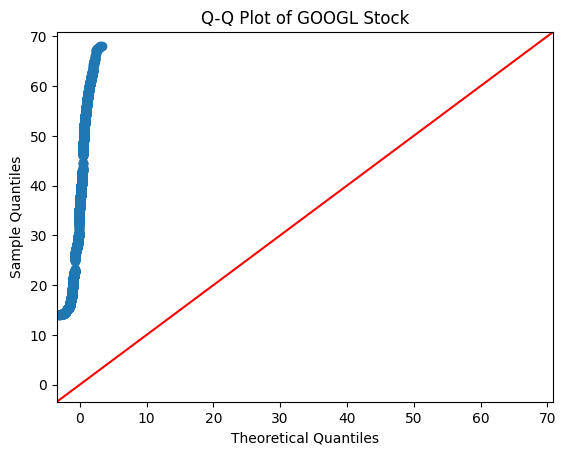

In [59]:
#plotting q-q plot

fig=sm.qqplot(df_googl['Adj Close'],line='45')
plt.title('Q-Q Plot of GOOGL Stock')
plt.show()

#As you can see we were right.

In [60]:
#Checking outliers for GOOGL

# Calculate IQR for 'Adj Close'
Q1 = df_googl['Adj Close'].quantile(0.25)
Q3 = df_googl['Adj Close'].quantile(0.75)
IQR = Q3 - Q1

# Define outliers as those below (Q1 - 1.5 * IQR) or above (Q3 + 1.5 * IQR)
outliers = df_googl[(df_googl['Adj Close'] < (Q1 - 1.5 * IQR)) | (df_googl['Adj Close'] > (Q3 + 1.5 * IQR))]

# Calculate the percentage of data points considered outliers
outlier_percentage = len(outliers) / len(df_googl) * 100

if outlier_percentage == 0:
     print_m = 'Analysis: There are no outliers in the dataset'
else:
     print_m = f'Analysis :There are {outlier_percentage} outliers in the dataset'

# Box Plot of Adj Close for identifying outliers
box_plot_fig = go.Figure()

box_plot_fig.add_trace(go.Box(
    y=df_googl['Adj Close'],
    name='GOOGL',
    boxpoints='outliers'
))

box_plot_fig.update_layout(
    title='Box Plot of Adjusted Close Prices of GOOGL Stock',
    xaxis_title='Adjusted Close Price',
    yaxis_title='',
    width=800,
    height=600,
    annotations=[
        dict(
          x = 0.01,
          y=-0.18,
          text = print_m,
          xref='paper',
          yref='paper',
          showarrow=False,
          font=dict(size=18, color="Dark Blue",family="bold italic"),
          align = "right",
        )

    ]
)

box_plot_fig.show()

# Feature Engineering

In [61]:
# Calculating moving averages
df_googl['MA50'] = df_googl['Adj Close'].rolling(50).mean()
df_googl['MA200'] = df_googl['Adj Close'].rolling(200).mean()

In [62]:
# Calculating Simple Moving Average for 5,10,15,20 days
df_googl['sma5'] = df_googl['Adj Close'].rolling(window = 5).mean()
df_googl['sma10'] = df_googl['Adj Close'].rolling(window = 10).mean()
df_googl['sma15'] = df_googl['Adj Close'].rolling(window = 15).mean()
df_googl['sma20'] = df_googl['Adj Close'].rolling(window = 20).mean()

In [63]:
#Calculating RSI

indicator_rsi = ta.momentum.RSIIndicator(close=df_googl['Adj Close'], window=14)
indicator_ema = ta.trend.EMAIndicator(close=df_googl['Adj Close'], window=9)
df_googl['RSI_14'] = indicator_rsi.rsi()
df_googl['EMA_9'] = indicator_ema.ema_indicator()
df_googl['MACD'] = df_googl['Adj Close'].ewm(span=12, adjust=False).mean() - df_googl['Adj Close'].ewm(span=26, adjust=False).mean()
df_googl['Signal_Line'] = df_googl['MACD'].ewm(span=9, adjust=False).mean()

In [64]:
# Creating a percent change feature
df_googl['pct_change'] = df_googl['Adj Close'].pct_change()

In [65]:
# Bollinger Bands
std_dev = df_googl['Adj Close'].rolling(window = 20).std()

#Upper and Lower Limits of Bollinger Bands
df_googl['ubb'] = df_googl['sma20'] + 2 * std_dev
df_googl['lbb'] = df_googl['sma20'] - 2 * std_dev

In [66]:
# Calculating True Range for accounting market volatality
df_googl['H-L'] = df_googl['High'] - df_googl['Low']
df_googl['H-PC'] = abs(df_googl['High'] - df_googl['Close'].shift(1))
df_googl['L-PC'] = abs(df_googl['Low'] - df_googl['Close'].shift(1))
df_googl['TR'] = df_googl[['H-L', 'H-PC', 'L-PC']].max(axis=1)

# Calculate ATR
df_googl['ATR'] = df_googl['TR'].rolling(window=1).mean()

# Drop intermediate columns
df_googl.drop(['H-L', 'H-PC', 'L-PC', 'TR'], axis=1, inplace=True)

In [67]:
# Calcuating On - Balance Volume
obv = []
prev_close = df_googl['Adj Close'].iloc[0]
obv.append(0)  # Initial OBV value
for i in range(1, len(df_googl)):
  if df_googl['Adj Close'].iloc[i] > prev_close:
    obv.append(obv[-1] + df_googl['Volume'].iloc[i])  # Add volume to OBV
  elif df_googl['Adj Close'].iloc[i] < prev_close:
    obv.append(obv[-1] - df_googl['Volume'].iloc[i])  # Subtract volume from OBV
  else:
    obv.append(obv[-1])  # No change in OBV
  prev_close = df_googl['Adj Close'].iloc[i]

# Add OBV to DataFrame
df_googl['OBV'] = obv

## Feature Engineering of the Target Stocks

In [68]:
#AAPL (to show how the model is generalising within industry)

# Calculating moving averages
df_aapl['MA50'] = df_aapl['Adj Close'].rolling(50).mean()
df_aapl['MA200'] = df_aapl['Adj Close'].rolling(200).mean()

# Calculating Simple Moving Average for 5,10,15,20 days
df_aapl['sma5'] = df_aapl['Adj Close'].rolling(window = 5).mean()
df_aapl['sma10'] = df_aapl['Adj Close'].rolling(window = 10).mean()
df_aapl['sma15'] = df_aapl['Adj Close'].rolling(window = 15).mean()
df_aapl['sma20'] = df_aapl['Adj Close'].rolling(window = 20).mean()

#Calculating RSI, EMA and MACD

indicator_rsi = ta.momentum.RSIIndicator(close=df_aapl['Adj Close'], window=14)
indicator_ema = ta.trend.EMAIndicator(close=df_aapl['Adj Close'], window=9)
df_aapl['RSI_14'] = indicator_rsi.rsi()
df_aapl['EMA_9'] = indicator_ema.ema_indicator()
df_aapl['MACD'] = df_aapl['Adj Close'].ewm(span=12, adjust=False).mean() - df_aapl['Adj Close'].ewm(span=26, adjust=False).mean()
df_aapl['Signal_Line'] = df_aapl['MACD'].ewm(span=9, adjust=False).mean()

# Creating a percent change feature
df_aapl['pct_change'] = df_aapl['Adj Close'].pct_change()

# Bollinger Bands
std_dev = df_aapl['Adj Close'].rolling(window = 20).std()

#Upper and Lower Limits of Bollinger Bands
df_aapl['ubb'] = df_aapl['sma20'] + 2 * std_dev
df_aapl['lbb'] = df_aapl['sma20'] - 2 * std_dev

# Calculating True Range for accounting market volatality
df_aapl['H-L'] = df_aapl['High'] - df_aapl['Low']
df_aapl['H-PC'] = abs(df_aapl['High'] - df_aapl['Close'].shift(1))
df_aapl['L-PC'] = abs(df_aapl['Low'] - df_aapl['Close'].shift(1))
df_aapl['TR'] = df_aapl[['H-L', 'H-PC', 'L-PC']].max(axis=1)

# Calculate ATR
df_aapl['ATR'] = df_aapl['TR'].rolling(window=1).mean()

# Drop intermediate columns
df_aapl.drop(['H-L', 'H-PC', 'L-PC', 'TR'], axis=1, inplace=True)

# Calcuating On - Balance Volume
obv = []
prev_close = df_aapl['Adj Close'].iloc[0]
obv.append(0)  # Initial OBV value
for i in range(1, len(df_aapl)):
  if df_aapl['Adj Close'].iloc[i] > prev_close:
    obv.append(obv[-1] + df_aapl['Volume'].iloc[i])  # Add volume to OBV
  elif df_aapl['Adj Close'].iloc[i] < prev_close:
    obv.append(obv[-1] - df_aapl['Volume'].iloc[i])  # Subtract volume from OBV
  else:
    obv.append(obv[-1])  # No change in OBV
  prev_close = df_aapl['Adj Close'].iloc[i]

# Add OBV to DataFrame
df_aapl['OBV'] = obv

In [69]:
#JNJ (to show how the model is generalising cross industry (Healthcare))

# Calculating moving averages
df_jnj['MA50'] = df_jnj['Adj Close'].rolling(50).mean()
df_jnj['MA200'] = df_jnj['Adj Close'].rolling(200).mean()

# Calculating Simple Moving Average for 5,10,15,20 days
df_jnj['sma5'] = df_jnj['Adj Close'].rolling(window = 5).mean()
df_jnj['sma10'] = df_jnj['Adj Close'].rolling(window = 10).mean()
df_jnj['sma15'] = df_jnj['Adj Close'].rolling(window = 15).mean()
df_jnj['sma20'] = df_jnj['Adj Close'].rolling(window = 20).mean()

#Calculating RSI, EMA and MACD

indicator_rsi = ta.momentum.RSIIndicator(close=df_jnj['Adj Close'], window=14)
indicator_ema = ta.trend.EMAIndicator(close=df_jnj['Adj Close'], window=9)
df_jnj['RSI_14'] = indicator_rsi.rsi()
df_jnj['EMA_9'] = indicator_ema.ema_indicator()
df_jnj['MACD'] = df_jnj['Adj Close'].ewm(span=12, adjust=False).mean() - df_jnj['Adj Close'].ewm(span=26, adjust=False).mean()
df_jnj['Signal_Line'] = df_jnj['MACD'].ewm(span=9, adjust=False).mean()

# Creating a percent change feature
df_jnj['pct_change'] = df_jnj['Adj Close'].pct_change()

# Bollinger Bands
std_dev = df_jnj['Adj Close'].rolling(window = 20).std()

#Upper and Lower Limits of Bollinger Bands
df_jnj['ubb'] = df_jnj['sma20'] + 2 * std_dev
df_jnj['lbb'] = df_jnj['sma20'] - 2 * std_dev

# Calculating True Range for accounting market volatality
df_jnj['H-L'] = df_jnj['High'] - df_jnj['Low']
df_jnj['H-PC'] = abs(df_jnj['High'] - df_jnj['Close'].shift(1))
df_jnj['L-PC'] = abs(df_jnj['Low'] - df_jnj['Close'].shift(1))
df_jnj['TR'] = df_jnj[['H-L', 'H-PC', 'L-PC']].max(axis=1)

# Calculate ATR
df_jnj['ATR'] = df_jnj['TR'].rolling(window=1).mean()

# Drop intermediate columns
df_jnj.drop(['H-L', 'H-PC', 'L-PC', 'TR'], axis=1, inplace=True)

# Calcuating On - Balance Volume
obv = []
prev_close = df_jnj['Adj Close'].iloc[0]
obv.append(0)  # Initial OBV value
for i in range(1, len(df_jnj)):
  if df_jnj['Adj Close'].iloc[i] > prev_close:
    obv.append(obv[-1] + df_jnj['Volume'].iloc[i])  # Add volume to OBV
  elif df_jnj['Adj Close'].iloc[i] < prev_close:
    obv.append(obv[-1] - df_jnj['Volume'].iloc[i])  # Subtract volume from OBV
  else:
    obv.append(obv[-1])  # No change in OBV
  prev_close = df_jnj['Adj Close'].iloc[i]

# Add OBV to DataFrame
df_jnj['OBV'] = obv

In [70]:
df_googl.head()

,Date,symbols,Adj Close,Close,High,Low,Open,Volume,MA50,MA200,...,sma20,RSI_14,EMA_9,MACD,Signal_Line,pct_change,ubb,lbb,ATR,OBV
0,2012-01-03,GOOGL,16.651901,16.651901,16.720470,16.325577,16.339840,146912940.0,NaN,NaN,...,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,0.394894,0.0
1,2012-01-04,GOOGL,16.723724,16.723724,16.773024,16.532032,16.642391,114445440.0,NaN,NaN,...,NaN,NaN,NaN,0.005729,0.001146,0.004313,NaN,NaN,0.240992,114445440.0
2,2012-01-05,GOOGL,16.491741,16.491741,16.615866,16.422173,16.569820,131184684.0,NaN,NaN,...,NaN,NaN,NaN,-0.008353,-0.000754,-0.013872,NaN,NaN,0.301552,-16739244.0
3,2012-01-06,GOOGL,16.266768,16.266768,16.516518,16.261011,16.495245,107608284.0,NaN,NaN,...,NaN,NaN,NaN,-0.037237,-0.008050,-0.013642,NaN,NaN,0.255507,-124347528.0
4,2012-01-09,GOOGL,15.577077,15.577077,16.191191,15.546296,16.178679,232671096.0,NaN,NaN,...,NaN,NaN,NaN,-0.114461,-0.029333,-0.042399,NaN,NaN,0.720471,-357018624.0


# Data Pre-processing

In [71]:
# Creating a lagged Target Column
df_googl['Target'] = df_googl['Adj Close'].shift(-1)

In [72]:
df_googl.tail()

,Date,symbols,Adj Close,Close,High,Low,Open,Volume,MA50,MA200,...,RSI_14,EMA_9,MACD,Signal_Line,pct_change,ubb,lbb,ATR,OBV,Target
2006,2019-12-23,GOOGL,67.531502,67.531502,68.092499,67.400002,67.936501,19936000.0,65.01362,60.330555,...,63.324980,67.434566,0.832736,0.853264,-0.000437,68.892231,64.382918,0.692497,3.409651e+09,67.221497
2007,2019-12-24,GOOGL,67.221497,67.221497,67.600502,67.208504,67.510498,13468000.0,65.14028,60.367350,...,59.104357,67.391952,0.767544,0.836120,-0.004591,68.909130,64.559968,0.391998,3.396183e+09,68.123497
2008,2019-12-26,GOOGL,68.123497,68.123497,68.160004,67.275497,67.327499,23662000.0,65.26051,60.408202,...,66.169654,67.538261,0.779675,0.824831,0.013418,69.054337,64.662111,0.938507,3.419845e+09,67.732002
2009,2019-12-27,GOOGL,67.732002,67.732002,68.352501,67.650002,68.199997,23212000.0,65.37215,60.448730,...,61.225525,67.577009,0.749064,0.809678,-0.005747,69.110713,64.818285,0.702499,3.396633e+09,66.985497
2010,2019-12-30,GOOGL,66.985497,66.985497,67.849998,66.891998,67.840500,19994000.0,65.45906,60.486082,...,53.081063,67.458707,0.656994,0.779141,-0.011021,69.033653,65.073445,0.958000,3.376639e+09,NaN


In [73]:
df_googl.dropna(axis=0,inplace=True)
df_googl=df_googl.set_index('Date').reset_index()

In [74]:
df_googl.isna().sum()

Date           0
symbols        0
Adj Close      0
Close          0
High           0
Low            0
Open           0
Volume         0
MA50           0
MA200          0
sma5           0
sma10          0
sma15          0
sma20          0
RSI_14         0
EMA_9          0
MACD           0
Signal_Line    0
pct_change     0
ubb            0
lbb            0
ATR            0
OBV            0
Target         0
dtype: int64

In [75]:
len(df_googl)

1811

In [76]:
df_googl.tail()

,Date,symbols,Adj Close,Close,High,Low,Open,Volume,MA50,MA200,...,RSI_14,EMA_9,MACD,Signal_Line,pct_change,ubb,lbb,ATR,OBV,Target
1806,2019-12-20,GOOGL,67.560997,67.560997,68.199997,67.536499,68.154999,50090000.0,64.87870,60.287712,...,63.727029,67.410332,0.872268,0.858396,-0.003848,68.868724,64.121625,0.663498,3.429587e+09,67.531502
1807,2019-12-23,GOOGL,67.531502,67.531502,68.092499,67.400002,67.936501,19936000.0,65.01362,60.330555,...,63.324980,67.434566,0.832736,0.853264,-0.000437,68.892231,64.382918,0.692497,3.409651e+09,67.221497
1808,2019-12-24,GOOGL,67.221497,67.221497,67.600502,67.208504,67.510498,13468000.0,65.14028,60.367350,...,59.104357,67.391952,0.767544,0.836120,-0.004591,68.909130,64.559968,0.391998,3.396183e+09,68.123497
1809,2019-12-26,GOOGL,68.123497,68.123497,68.160004,67.275497,67.327499,23662000.0,65.26051,60.408202,...,66.169654,67.538261,0.779675,0.824831,0.013418,69.054337,64.662111,0.938507,3.419845e+09,67.732002
1810,2019-12-27,GOOGL,67.732002,67.732002,68.352501,67.650002,68.199997,23212000.0,65.37215,60.448730,...,61.225525,67.577009,0.749064,0.809678,-0.005747,69.110713,64.818285,0.702499,3.396633e+09,66.985497


In [77]:
df_googl=df_googl.drop(['Adj Close','Close','High','Low','Open','symbols'],axis=1)

In [78]:
# Checking for Infinity values
is_inf = df_googl.isin([np.inf,-np.inf]).values.any()
print(is_inf)

# Checking for duplicates
duplicated = df_googl.duplicated().values.any()
print(duplicated)

False
False


In [79]:
# Splitting the data into training and testing sets
X=df_googl.drop(['Target'],axis=1)
y=df_googl['Target']
scaler=RobustScaler()

X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=False)
X_train_unscaled_no_date=X_train_unscaled.drop(['Date'],axis=1)
X_test_unscaled_no_date=X_test_unscaled.drop(['Date'],axis=1)

X_train=scaler.fit_transform(X_train_unscaled_no_date)
X_test=scaler.transform(X_test_unscaled_no_date)
X_train=pd.DataFrame(X_train,columns=X_train_unscaled_no_date.columns)
X_test=pd.DataFrame(X_test,columns=X_test_unscaled_no_date.columns)
X_train['Date']=X_train_unscaled['Date']
X_train=X_train.set_index('Date')
X_test_unscaled.reset_index(drop=True,inplace=True)
X_test['Date']=X_test_unscaled['Date']
X_test=X_test.set_index('Date')

In [80]:
X_train.tail(1)

,Volume,MA50,MA200,sma5,sma10,sma15,sma20,RSI_14,EMA_9,MACD,Signal_Line,pct_change,ubb,lbb,ATR,OBV
Date,,,,,,,,,,,,,,,,
2018-07-19,-0.042417,1.823608,1.859535,1.802892,1.793752,1.754413,1.737693,0.425822,1.808044,1.582927,1.2855,-0.872666,1.753495,1.641444,1.085504,0.78237


In [81]:
X_test.head(1)

,Volume,MA50,MA200,sma5,sma10,sma15,sma20,RSI_14,EMA_9,MACD,Signal_Line,pct_change,ubb,lbb,ATR,OBV
Date,,,,,,,,,,,,,,,,
2018-07-20,-0.053858,1.83151,1.863661,1.798551,1.808233,1.770533,1.742547,0.396642,1.81224,1.535015,1.357014,-0.116322,1.764129,1.640273,0.519216,0.758098


## Pre processing of target stocks 

In [82]:
#AAPL

# Creating Target Column
df_aapl['Target'] = df_aapl['Adj Close'].shift(-1)

df_aapl.dropna(axis=0,inplace=True)
df_aapl=df_aapl.set_index('Date').reset_index()

df_aapl=df_aapl.drop(['Adj Close','Close','High','Low','Open','symbols'],axis=1)

# Checking for Infinity values
is_inf = df_aapl.isin([np.inf,-np.inf]).values.any()
print(is_inf)

# Checking for duplicates
duplicated = df_aapl.duplicated().values.any()
print(duplicated)

X_aapl=df_aapl.drop(['Target'],axis=1)
y_aapl=df_aapl['Target']
X_train_unscaled_aapl, X_test_unscaled_aapl, y_train_aapl, y_test_aapl = train_test_split(X_aapl, y_aapl, test_size=0.2,shuffle=False)
X_train_unscaled_aapl_no_date=X_train_unscaled_aapl.drop(['Date'],axis=1)
X_test_unscaled_aapl_no_date=X_test_unscaled_aapl.drop(['Date'],axis=1)

X_train_aapl=scaler.transform(X_train_unscaled_aapl_no_date)
X_test_aapl=scaler.transform(X_test_unscaled_aapl_no_date)
X_train_aapl=pd.DataFrame(X_train_aapl,columns=X_train_unscaled_aapl_no_date.columns)
X_test_aapl=pd.DataFrame(X_test_aapl,columns=X_test_unscaled_aapl_no_date.columns)
X_train_aapl['Date']=X_train_unscaled_aapl['Date']
X_train_aapl=X_train_aapl.set_index('Date')
X_test_unscaled_aapl.reset_index(drop=True,inplace=True)
X_test_aapl['Date']=X_test_unscaled_aapl['Date']
X_test_aapl=X_test_aapl.set_index('Date')

X_test_aapl.head(1)

False
False


,Volume,MA50,MA200,sma5,sma10,sma15,sma20,RSI_14,EMA_9,MACD,Signal_Line,pct_change,ubb,lbb,ATR,OBV
Date,,,,,,,,,,,,,,,,
2018-07-20,1.226583,0.958132,0.928697,0.823556,0.842806,0.838083,0.818683,0.191119,0.843495,0.272844,0.087807,-0.20937,0.739956,0.837128,0.162326,-0.517793


In [83]:
#JNJ

# Creating Target Column
df_jnj['Target'] = df_jnj['Adj Close'].shift(-1)

df_jnj.dropna(axis=0,inplace=True)
df_jnj=df_jnj.set_index('Date').reset_index()

df_jnj=df_jnj.drop(['Adj Close','Close','High','Low','Open','symbols'],axis=1)

# Checking for Infinity values
is_inf = df_jnj.isin([np.inf,-np.inf]).values.any()
print(is_inf)

# Checking for duplicates
duplicated = df_jnj.duplicated().values.any()
print(duplicated)

X_jnj=df_jnj.drop(['Target'],axis=1)
y_jnj=df_jnj['Target']
X_train_unscaled_jnj, X_test_unscaled_jnj, y_train_jnj, y_test_jnj = train_test_split(X_jnj, y_jnj, test_size=0.2,shuffle=False)
X_train_unscaled_jnj_no_date=X_train_unscaled_jnj.drop(['Date'],axis=1)
X_test_unscaled_jnj_no_date=X_test_unscaled_jnj.drop(['Date'],axis=1)

X_train_jnj=scaler.transform(X_train_unscaled_jnj_no_date)
X_test_jnj=scaler.transform(X_test_unscaled_jnj_no_date)
X_train_jnj=pd.DataFrame(X_train_jnj,columns=X_train_unscaled_jnj_no_date.columns)
X_test_jnj=pd.DataFrame(X_test_jnj,columns=X_test_unscaled_jnj_no_date.columns)
X_train_jnj['Date']=X_train_unscaled_jnj['Date']
X_train_jnj=X_train_jnj.set_index('Date')
X_test_unscaled_jnj.reset_index(drop=True,inplace=True)
X_test_jnj['Date']=X_test_unscaled_jnj['Date']
X_test_jnj=X_test_jnj.set_index('Date')

X_test_jnj.head(1)

False
False


,Volume,MA50,MA200,sma5,sma10,sma15,sma20,RSI_14,EMA_9,MACD,Signal_Line,pct_change,ubb,lbb,ATR,OBV
Date,,,,,,,,,,,,,,,,
2018-07-20,-0.97207,5.362813,6.102506,4.997597,5.106093,5.08307,5.05152,-0.072168,5.087868,1.417536,1.280172,-0.09424,5.053179,4.905954,1.289957,-0.800205


In [85]:
len(df_googl)==len(df_aapl)==len(df_jnj)

True

# Feature Selection

In [86]:
# Calculate the Pearson correlation matrix
df_= df_googl.drop(columns=['Date'])
corr_matrix_features = df_.corr()

# Visualise the correlation matrix using a heatmap
corr_features_fig = go.Figure(data=go.Heatmap(
  z=corr_matrix_features.values,
  x=corr_matrix_features.columns,
  y=corr_matrix_features.index,
  colorscale='Blues',
  colorbar=dict(title='Coefficients'),
))

corr_features_fig.update_layout(
  title='Correlation between features',
  width=800,
  height=500,
)

corr_features_fig.show()

print('\n')

# Specifically, looking at correlations with the 'Adj Close' price
print("Correlation with Target:")
print(corr_matrix_features['Target'].sort_values(ascending=False))



Correlation with Target:
Target         1.000000
sma5           0.997960
EMA_9          0.997717
sma10          0.996806
sma15          0.995896
sma20          0.995040
ubb            0.993203
lbb            0.992712
MA50           0.989358
MA200          0.980728
OBV            0.932046
ATR            0.482816
Signal_Line    0.178362
MACD           0.176817
RSI_14         0.107784
pct_change     0.015812
Volume        -0.443438
Name: Target, dtype: float64


In [87]:
#LASSO REGRESSION

# Initialise and train the Lasso model with cross-validation to find the best alpha
lasso = LassoCV(cv=5, random_state=42).fit(X_train, y_train)

# Display the coefficients
coefficients = lasso.coef_

feature_names = X_train.columns
feature_importances = sorted(zip(coefficients, feature_names), reverse=True)

# Print non-zero coefficients and their corresponding feature names
print("Selected Features and their Coefficients:")
features_selected=[]
for coef, feature in feature_importances:
    if coef > 0:
        features_selected.append(feature)
        print(f"{feature}: {round(coef,3)}")

Selected Features and their Coefficients:
MA50: 6.807
sma5: 4.514
sma20: 2.121
MACD: 0.745
RSI_14: 0.677
ubb: 0.519
MA200: 0.451
pct_change: 0.232


In [88]:
strong_candidates= features_selected

In [89]:
strong_candidates.append('lbb') #Because lbb works together with ubb

In [90]:
strong_candidates.append('EMA_9') #Because of the domain knowledge 

In [91]:
strong_candidates

['MA50',
 'sma5',
 'sma20',
 'MACD',
 'RSI_14',
 'ubb',
 'MA200',
 'pct_change',
 'lbb',
 'EMA_9']

# Training and testing the model

In [92]:
# Creating baseline with Industry Standards
r2_baseline = r2_score(y_test, X_test_unscaled['sma5'])
mse_baseline = mean_squared_error(y_test,X_test_unscaled['sma5'])
mae_baseline = mean_absolute_error(y_test, X_test_unscaled['sma5'])
rmse_baseline = mean_squared_error(y_test, X_test_unscaled['sma5'], squared=False)
print(f'R² Score: {round(r2_baseline,3)}')
print(f"Mean Squared Error: {round(mse_baseline,3)}")
print(f"Mean Absolute Error: {round(mae_baseline, 3)}")
print(f"Root Mean Squared Error: {round(rmse_baseline, 3)}")

R² Score: 0.911
Mean Squared Error: 1.521
Mean Absolute Error: 0.949
Root Mean Squared Error: 1.233


In [93]:
#MODEL TRAINING and TESTING

#Linear Regression

model_lr = LinearRegression()
model_lr.fit(X_train[strong_candidates], y_train)

# Predict and evaluate

predictions_lr = model_lr.predict(X_test[strong_candidates])

mse_lr = mean_squared_error(y_test, predictions_lr)
r2_lr = r2_score(y_test, predictions_lr)
mae_lr = mean_absolute_error(y_test, predictions_lr)
rmse_lr = mean_squared_error(y_test, predictions_lr, squared=False)


print(f'R² Score: {round(r2_lr,3)}')
print(f"Mean Squared Error: {round(mse_lr,3)}")
print(f"Mean Absolute Error: {round(mae_lr, 3)}")
print(f"Root Mean Squared Error: {round(rmse_lr, 3)}")

R² Score: 0.936
Mean Squared Error: 1.091
Mean Absolute Error: 0.767
Root Mean Squared Error: 1.044


Testing the residuals to see if the assumptions of linear regression are met 

In [94]:
# Creating a new data frame of Actual, Predicted and Residual y values
y_test_series = pd.Series(y_test, name='Actual')
predictions_series = pd.Series(predictions_lr, name='Predicted')

# Concatenate them into a DataFrame
res_df = pd.concat([y_test_series.reset_index(drop=True), predictions_series.reset_index(drop=True)], axis=1)

# Now res_df is a DataFrame with two columns: 'Actual' and 'Predicted'

res_df['Residuals']=res_df['Actual']-res_df['Predicted']
res_df['Date']=X_test.index
res_df=res_df.set_index('Date')
res_df.head()

,Actual,Predicted,Residuals
Date,,,
2018-07-20,60.549999,60.005332,0.544667
2018-07-23,62.907501,60.534839,2.372662
2018-07-24,63.797001,61.865454,1.931547
2018-07-25,64.275002,62.154143,2.120858
2018-07-26,62.644501,62.681349,-0.036849


In [95]:
#Test for Linearity

# Calculate the minimum and maximum values to set appropriate limits for the line
line_coords = np.arange(res_df[['Actual', 'Predicted']].min().min() - 10,
                        res_df[['Actual', 'Predicted']].max().max() + 10)

# Plotting Linearity
linearity_fig = go.Figure()

# Add the scatter plot points
linearity_fig.add_trace(go.Scatter(
    x=res_df['Actual'],
    y=res_df['Predicted'],
    mode='markers',
    name='Actual vs Predicted',
    marker=dict(color='blue')
))

# Add the line plot for the diagonal
linearity_fig.add_trace(go.Scatter(
    x=line_coords,
    y=line_coords,
    mode='lines',
    name='Linearity Reference',
    line=dict(color='darkorange', dash='dash')
))

# Labeling
linearity_fig.update_layout(
    title='Linearity Assumption',
    xaxis_title='Actual',
    yaxis_title='Predicted',
    autosize=False,
    width=800,
    height=500,
)

linearity_fig.show()

In [98]:
#Test for Normality

# Performing the test on the residuals
p_value = normal_ad(res_df['Residuals'])[1]

# Plotting the residuals distribution
kernel_desity = gaussian_kde(res_df['Residuals'])
x_range = np.linspace(res_df['Residuals'].min(), res_df['Residuals'].max(),1000)
kernel_density_values = kernel_desity(x_range)

# Reporting the normality of the residuals
if p_value < 0.05:
    normality_message = 'Analysis: Residuals are not normally distributed'
else:
    normality_message = 'Analysis: Residuals are normally distributed'

# Plotting the residuals distribution
normality_fig = go.Figure()

# Add histogram data
normality_fig.add_trace(go.Histogram(
    x=res_df['Residuals'],
    histnorm='probability density',  # Normalizing to form a probability density
    name='Histogram',
    opacity=0.6
))

# Add the KDE line
normality_fig.add_trace(go.Scatter(
    x=x_range,
    y=kernel_density_values,
    mode='lines',
    name='KDE',
    line=dict(color='red')
))

normality_fig.add_annotation(
    go.layout.Annotation(
        x=0,
        y=-0.25,
        xref='paper',
        yref='paper',
        text=f'Anderson-Darling p-value: {p_value}',
        showarrow=False,
        font=dict(
            size=15,
            color="Dark Blue",family="bold italic"
        )
    )
)

normality_fig.add_annotation(
    go.layout.Annotation(
        x=0,
        y=-0.32,
        xref='paper',
        yref='paper',
        text=normality_message,
        showarrow=False,
        font=dict(
            size=15,
            color="Dark Blue",family="bold italic"
        )
    )
)

normality_fig.update_layout(
    title='Distribution of Residuals',
    xaxis_title='Residuals',
    yaxis_title='Density',
    bargap=0.05,
    template='plotly_white',
    width = 800,
    height = 500,
    margin=dict(
        b=100, # bottom margin increased to 100
    ),
    yaxis=dict(showgrid=True)
)


# Show the plot
normality_fig.show()


In [99]:
#Test for autocorrelation

durbinWatson = durbin_watson(res_df['Residuals'])

print('Durbin-Watson:', durbinWatson)
if durbinWatson < 1.5:
    print('Signs of positive autocorrelation', '\n')

elif durbinWatson > 2.5:
    print('Signs of negative autocorrelation', '\n')
    
else:
    print('Little to no autocorrelation', '\n')

Durbin-Watson: 1.1529423288212177
Signs of positive autocorrelation 



In [100]:
#Test for Homoscedasticity

# Add a constant to the predictors for the intercept
X_test_with_const = sm.add_constant(X_test)

# Perform the Breusch-Pagan test
bp_test = het_breuschpagan(res_df.Residuals, X_test_with_const)

# The function returns four values: LM statistic, LM p-value, F-statistic, and F-test p-value
lm_stat, lm_pvalue, f_stat, f_pvalue = bp_test

if lm_pvalue < 0.05:
    homoscadacity_message = "Analysis: There is evidence of heteroscedasticity, indicating the assumption of homoscedasticity is not satisfied."
else:
    homoscadacity_message = "Analysis: No evidence of heteroscedasticity, the assumption of homoscedasticity is satisfied."

# Creating a scatter plot for residuals
homoscadacity_fig = go.Figure()
homoscadacity_fig.add_trace(go.Scatter(
    x=res_df.index,
    y=res_df['Residuals'],
    mode='markers',
    name='Residuals',
    marker=dict(color='blue', opacity=0.8)
))

# Adding a horizontal line at y=0
homoscadacity_fig.add_shape(
    type="line",
    x0=res_df.index.min(),
    y0=0,
    x1=res_df.index.max(),
    y1=0,
    line=dict(
        color="darkorange",
        width=2,
        dash="dash",
    )
)

homoscadacity_fig.add_annotation(
    go.layout.Annotation(
        x=0,
        y=-0.6,
        xref='paper',
        yref='paper',
        text=f'Breusch-Pagan p-value: {lm_pvalue}',
        showarrow=False,
        font=dict(
            size=15,
            color="Dark Blue",family="bold italic"
        )
    )
)

homoscadacity_fig.add_annotation(
    go.layout.Annotation(
        x=0,
        y=-0.7,
        xref='paper',
        yref='paper',
        text=homoscadacity_message,
        showarrow=False,
        font=dict(
            size=15,
            color="Dark Blue",family="bold italic"
        )
    )
)

# Setting the labels and title of the plot
homoscadacity_fig.update_layout(
    title='Homoscedasticity Assumption',
    xaxis=dict(title='Date', tickangle=45),
    yaxis=dict(title='Residual'),
    autosize=False,
    width=800,
    height=500,
     margin=dict(
        b=175, # bottom margin increased to 100
    )
)

homoscadacity_fig.show()

In [102]:
# SVR

# Hyperparameter tuning with GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100,1000],
    'epsilon': [0.01, 0.1, 1],
    'kernel': ['linear']
}

tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(SVR(), param_grid, cv=tscv, verbose=1, n_jobs=-1,scoring='r2')
grid_search.fit(X_train[strong_candidates], y_train)

# Best hyperparameters
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

# Best model
model_svm = grid_search.best_estimator_

# Predictions with the best model
predictions_svm = model_svm.predict(X_test[strong_candidates])

# Evaluate the best model
mse_svm = mean_squared_error(y_test, predictions_svm)
r2_svm = r2_score(y_test, predictions_svm)
mae_svm = mean_absolute_error(y_test, predictions_svm)
rmse_svm = mean_squared_error(y_test, predictions_svm, squared=False)

print(f"R² Score: {round(r2_svm, 3)}")
print(f"Mean Squared Error: {round(mse_svm, 3)}")
print(f"Mean Absolute Error: {round(mae_svm, 3)}")
print(f"Root Mean Squared Error: {round(rmse_svm, 3)}")

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best hyperparameters: {'C': 100, 'epsilon': 0.1, 'kernel': 'linear'}
R² Score: 0.932
Mean Squared Error: 1.161
Mean Absolute Error: 0.79
Root Mean Squared Error: 1.078


In [103]:
#LSTM

# Before initialiSing the model
clear_session()

# Now, reshape the scaled data for LSTM input
X_train_array = X_train[strong_candidates].to_numpy()
X_test_array = X_test[strong_candidates].to_numpy()

X_train_reshaped = X_train_array.reshape((X_train_array.shape[0], 1, X_train_array.shape[1]))
X_test_reshaped = X_test_array.reshape((X_test_array.shape[0], 1, X_test_array.shape[1]))

# LSTM Model Setup
model_lstm = Sequential()

# Adding two LSTM layers with Dropout for regularization
# First LSTM layer with return_sequences=True to pass sequences to the next LSTM layer
model_lstm.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(1, X_train_reshaped.shape[2])))
model_lstm.add(Dropout(0.2))  # Dropout to prevent overfitting

# Second LSTM layer
model_lstm.add(LSTM(20, activation='relu'))
model_lstm.add(Dropout(0.2))  # Additional dropout layer

# Output layer with one neuron as we are predicting a continuous value
model_lstm.add(Dense(1))

# Compiling the model with an adjusted learning rate
optimizer = Adam(learning_rate=0.001)
model_lstm.compile(optimizer=optimizer, loss='mae')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

r2_threshold = 0.9
current_r2 = 0
r2_scores, maes, mses, rmses = [], [], [], []

# Loop until the R² score exceeds the threshold
# Training the model with early stopping
while current_r2 < r2_threshold:
    # Fit the model
    model_lstm.fit(
        X_train_reshaped, 
        y_train, 
        epochs=100, 
        batch_size=32, 
        verbose=0, 
        validation_split=0.1, 
        callbacks=[early_stopping]
    )

    # Predict with the LSTM model
    predictions_lstm = model_lstm.predict(X_test_reshaped).flatten()  # Flatten to match y_test's shape

    # Evaluate LSTM model performance
    current_r2 = r2_score(y_test, predictions_lstm)

    r2 = r2_score(y_test, predictions_lstm)
    mse = mean_squared_error(y_test, predictions_lstm)
    mae = mean_absolute_error(y_test, predictions_lstm)
    rmse = mean_squared_error(y_test, predictions_lstm, squared=False)
    
    # Append metrics to lists
    r2_scores.append(r2)
    mses.append(mse)
    maes.append(mae)
    rmses.append(rmse)

    # Break if the model is good enough
    if current_r2 >= r2_threshold:

        break

# Evaluate LSTM model performance
mse_lstm = mean_squared_error(y_test, predictions_lstm)
r2_lstm = r2_score(y_test, predictions_lstm)
mae_lstm = mean_absolute_error(y_test, predictions_lstm)
rmse_lstm = mean_squared_error(y_test, predictions_lstm, squared=False)

print(f'R² Score: {round(r2_lstm,3)}')
print(f"Mean Squared Error: {round(mse_lstm,3)}")
print(f"Mean Absolute Error: {round(mae_lstm, 3)}")
print(f"Root Mean Squared Error: {round(rmse_lstm, 3)}")

# Calculate mean of each metric
mean_r2, std_r2 = np.mean(r2_scores), np.std(r2_scores)
mean_mse, std_mse = np.mean(mses), np.std(mses)
mean_mae, std_mae = np.mean(maes), np.std(maes)
mean_rmse, std_rmse = np.mean(rmses), np.std(rmses)

# Output the means and standard deviations of the metrics
print('')
print(f'Mean R² Score: {mean_r2:.3f}, Std Dev: {std_r2:.3f}')
print(f"Mean MSE: {mean_mse:.3f}, Std Dev: {std_mse:.3f}")
print(f"Mean MAE: {mean_mae:.3f}, Std Dev: {std_mae:.3f}")
print(f"Mean RMSE: {mean_rmse:.3f}, Std Dev: {std_rmse:.3f}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
R² Score: 0.904
Mean Squared Error: 1.644
Mean Absolute Error: 1.017
Root Mean Squared Error: 1.282

Mean R² Score: 0.6

In [105]:
# Plotting LR VS SVR VS LSTM
model_performance_fig_googl = make_subplots(rows=1, cols=1, shared_xaxes=True)

# Actual and Predicted prices for all models
model_performance_fig_googl.add_trace(go.Scatter(x=X_test.index, y=y_test, mode='lines', name='Actual', line=dict(color='navy')))
model_performance_fig_googl.add_trace(go.Scatter(x=X_test.index, y=X_test_unscaled['sma5'], mode='lines', name='Baseline Predicted', line=dict(color='brown', dash='dot')))
model_performance_fig_googl.add_trace(go.Scatter(x=X_test.index, y=predictions_lr, mode='lines', name='LR Predicted', line=dict(color='darkcyan', dash='dot')))
model_performance_fig_googl.add_trace(go.Scatter(x=X_test.index, y=predictions_svm, mode='lines', name='SVM Predicted', line=dict(color='red', dash='dot')))
model_performance_fig_googl.add_trace(go.Scatter(x=X_test.index, y=predictions_lstm, mode='lines', name='LSTM Predicted', line=dict(color='orange', dash='dot')))



model_performance_fig_googl.update_layout(
    title_text='Actual vs. Predicted Prices for GOOGL',
    xaxis_title='Date',
    yaxis_title='Price',
    legend=dict(orientation='v', yanchor='bottom', y=1, xanchor='right', x=1)
)

# Show the figure
model_performance_fig_googl.show()

# Predictive performance of the model on the target stock within industry (AAPL)

In [108]:
# Creating baseline with Industry Standards
r2_baseline_aapl = r2_score(y_test_aapl, X_test_unscaled_aapl['sma5'])
mse_baseline_aapl = mean_squared_error(y_test_aapl,X_test_unscaled_aapl['sma5'])
mae_baseline_aapl = mean_absolute_error(y_test_aapl, X_test_unscaled_aapl['sma5'])
rmse_baseline_aapl = mean_squared_error(y_test_aapl, X_test_unscaled_aapl['sma5'], squared=False)
print(f'R² Score: {round(r2_baseline_aapl,3)}')
print(f"Mean Squared Error: {round(mse_baseline_aapl,3)}")
print(f"Mean Absolute Error: {round(mae_baseline_aapl, 3)}")
print(f"Root Mean Squared Error: {round(rmse_baseline_aapl, 3)}")

R² Score: 0.975
Mean Squared Error: 1.452
Mean Absolute Error: 0.944
Root Mean Squared Error: 1.205


In [106]:
#Predicting on AAPL (LR)

predictions_lr_aapl = model_lr.predict(X_test_aapl[strong_candidates])

mse_lr_aapl = mean_squared_error(y_test_aapl, predictions_lr_aapl)
r2_lr_aapl = r2_score(y_test_aapl, predictions_lr_aapl)
mae_lr_aapl = mean_absolute_error(y_test_aapl, predictions_lr_aapl)
rmse_lr_aapl = mean_squared_error(y_test_aapl, predictions_lr_aapl, squared=False)


print(f'R² Score: {round(r2_lr_aapl,3)}')
print(f"Mean Squared Error: {round(mse_lr_aapl,3)}")
print(f"Mean Absolute Error: {round(mae_lr_aapl, 3)}")
print(f"Root Mean Squared Error: {round(rmse_lr_aapl, 3)}")

R² Score: 0.976
Mean Squared Error: 1.406
Mean Absolute Error: 0.908
Root Mean Squared Error: 1.186


In [109]:
#Predicting on AAPL (SVR)

# Predictions with the best model
predictions_svm_aapl = model_svm.predict(X_test_aapl[strong_candidates])

# Evaluate the best model
mse_svm_aapl = mean_squared_error(y_test_aapl, predictions_svm_aapl)
r2_svm_aapl = r2_score(y_test_aapl, predictions_svm_aapl)
mae_svm_aapl = mean_absolute_error(y_test_aapl, predictions_svm_aapl)
rmse_svm_aapl = mean_squared_error(y_test_aapl, predictions_svm_aapl, squared=False)


print(f"R² Score: {round(r2_svm_aapl, 3)}")
print(f"Mean Squared Error: {round(mse_svm_aapl, 3)}")
print(f"Mean Absolute Error: {round(mae_svm_aapl, 3)}")
print(f"Root Mean Squared Error: {round(rmse_svm_aapl, 3)}")

R² Score: 0.976
Mean Squared Error: 1.408
Mean Absolute Error: 0.898
Root Mean Squared Error: 1.186


In [110]:
#Predicting on AAPL (LSTM)

X_test_array_aapl = X_test_aapl[strong_candidates].to_numpy()
X_test_reshaped_aapl = X_test_array_aapl.reshape((X_test_array_aapl.shape[0], 1, X_test_array_aapl.shape[1]))

# Predict with the LSTM model
predictions_lstm_aapl = model_lstm.predict(X_test_reshaped_aapl).flatten()  # Flatten to match y_test's shape

# Evaluate LSTM model performance
mse_lstm_aapl = mean_squared_error(y_test_aapl, predictions_lstm_aapl)
r2_lstm_aapl = r2_score(y_test_aapl, predictions_lstm_aapl)
mae_lstm_aapl = mean_absolute_error(y_test_aapl, predictions_lstm_aapl)
rmse_lstm_aapl = mean_squared_error(y_test_aapl, predictions_lstm_aapl, squared=False)

print(f'R² Score: {round(r2_lstm_aapl,3)}')
print(f"Mean Squared Error: {round(mse_lstm_aapl,3)}")
print(f"Mean Absolute Error: {round(mae_lstm_aapl, 3)}")
print(f"Root Mean Squared Error: {round(rmse_lstm_aapl, 3)}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
R² Score: 0.929
Mean Squared Error: 4.165
Mean Absolute Error: 1.599
Root Mean Squared Error: 2.041


In [111]:
#Visualising performance

In [112]:
# Plotting
model_performance_fig_aapl = make_subplots(rows=1, cols=1)

# Actual and Predicted prices for all models
model_performance_fig_aapl.add_trace(go.Scatter(x=X_test.index, y=y_test_aapl, name='AAPL Actual', line=dict(color='navy')), row=1, col=1)
model_performance_fig_aapl.add_trace(go.Scatter(x=X_test.index, y=X_test_unscaled_aapl['sma5'], mode='lines', name='Baseline Predicted', line=dict(color='brown', dash='dot')),row = 1,col = 1)
model_performance_fig_aapl.add_trace(go.Scatter(x=X_test.index, y=predictions_lr_aapl, name='LR Predicted', line=dict(color='darkcyan', dash='dot')), row=1, col=1)
model_performance_fig_aapl.add_trace(go.Scatter(x=X_test.index, y=predictions_svm_aapl, name='SVM Predicted', line=dict(color='red', dash='dot')), row=1, col=1)
model_performance_fig_aapl.add_trace(go.Scatter(x=X_test.index, y=predictions_lstm_aapl, name='LSTM Predicted', line=dict(color='orange', dash='dot')), row=1, col=1)


model_performance_fig_aapl.update_layout(
    title_text='Actual vs. Predicted Prices for AAPL',
    xaxis_title='Date',
    yaxis_title='Price',
    legend=dict(orientation='v', yanchor='bottom', y=1, xanchor='right', x=1)
)

# Show the figure
model_performance_fig_aapl.show()

# Predictive performance of the model on correlated target stock cross industry (JNJ)

In [113]:
# Creating baseline with Industry Standards
r2_baseline_jnj = r2_score(y_test_jnj, X_test_unscaled_jnj['sma5'])
mse_baseline_jnj = mean_squared_error(y_test_jnj,X_test_unscaled_jnj['sma5'])
mae_baseline_jnj = mean_absolute_error(y_test_jnj, X_test_unscaled_jnj['sma5'])
rmse_baseline_jnj = mean_squared_error(y_test_jnj, X_test_unscaled_jnj['sma5'], squared=False)
print(f'R² Score: {round(r2_baseline_jnj,3)}')
print(f"Mean Squared Error: {round(mse_baseline_jnj,3)}")
print(f"Mean Absolute Error: {round(mae_baseline_jnj, 3)}")
print(f"Root Mean Squared Error: {round(rmse_baseline_jnj, 3)}")

R² Score: 0.805
Mean Squared Error: 4.314
Mean Absolute Error: 1.455
Root Mean Squared Error: 2.077


In [114]:
#Predicting on JNJ (LR)

predictions_lr_jnj = model_lr.predict(X_test_jnj[strong_candidates])

mse_lr_jnj = mean_squared_error(y_test_jnj, predictions_lr_jnj)
r2_lr_jnj = r2_score(y_test_jnj, predictions_lr_jnj)
mae_lr_jnj = mean_absolute_error(y_test_jnj, predictions_lr_jnj)
rmse_lr_jnj = mean_squared_error(y_test_jnj, predictions_lr_jnj, squared=False)


print(f'R² Score: {round(r2_lr_jnj,3)}')
print(f"Mean Squared Error: {round(mse_lr_jnj,3)}")
print(f"Mean Absolute Error: {round(mae_lr_jnj, 3)}")
print(f"Root Mean Squared Error: {round(rmse_lr_jnj, 3)}")

R² Score: 0.822
Mean Squared Error: 3.946
Mean Absolute Error: 1.395
Root Mean Squared Error: 1.986


In [115]:
#Predicting on JNJ (SVR)

# Predictions with the best model
predictions_svm_jnj = model_svm.predict(X_test_jnj[strong_candidates])

# Evaluate the best model
mse_svm_jnj = mean_squared_error(y_test_jnj, predictions_svm_jnj)
r2_svm_jnj = r2_score(y_test_jnj, predictions_svm_jnj)
mae_svm_jnj = mean_absolute_error(y_test_jnj, predictions_svm_jnj)
rmse_svm_jnj = mean_squared_error(y_test_jnj, predictions_svm_jnj, squared=False)


print(f"R² Score: {round(r2_svm_jnj, 3)}")
print(f"Mean Squared Error: {round(mse_svm_jnj, 3)}")
print(f"Mean Absolute Error: {round(mae_svm_jnj, 3)}")
print(f"Root Mean Squared Error: {round(rmse_svm_jnj, 3)}")

R² Score: 0.811
Mean Squared Error: 4.19
Mean Absolute Error: 1.405
Root Mean Squared Error: 2.047


In [116]:
#Predicting on JNJ (LSTM)

X_test_array_jnj = X_test_jnj[strong_candidates].to_numpy()
X_test_reshaped_jnj = X_test_array_jnj.reshape((X_test_array_jnj.shape[0], 1, X_test_array_jnj.shape[1]))

# Predict with the LSTM model
predictions_lstm_jnj = model_lstm.predict(X_test_reshaped_jnj).flatten()  # Flatten to match y_test's shape

# Evaluate LSTM model performance
mse_lstm_jnj = mean_squared_error(y_test_jnj, predictions_lstm_jnj)
r2_lstm_jnj = r2_score(y_test_jnj, predictions_lstm_jnj)
mae_lstm_jnj = mean_absolute_error(y_test_jnj, predictions_lstm_jnj)
rmse_lstm_jnj = mean_squared_error(y_test_jnj, predictions_lstm_jnj, squared=False)

print(f'R² Score: {round(r2_lstm_jnj,3)}')
print(f"Mean Squared Error: {round(mse_lstm_jnj,3)}")
print(f"Mean Absolute Error: {round(mae_lstm_jnj, 3)}")
print(f"Root Mean Squared Error: {round(rmse_lstm_jnj, 3)}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
R² Score: -2.555
Mean Squared Error: 78.7
Mean Absolute Error: 8.392
Root Mean Squared Error: 8.871


In [118]:
# Plotting
model_performance_fig_jnj = make_subplots(rows=1, cols=1)

# Actual and Predicted prices for all models
model_performance_fig_jnj.add_trace(go.Scatter(x=X_test.index, y=y_test_jnj, name='AAPL Actual', line=dict(color='navy')), row=1, col=1)
model_performance_fig_jnj.add_trace(go.Scatter(x=X_test.index, y=X_test_unscaled_jnj['sma5'], mode='lines', name='Baseline Predicted', line=dict(color='brown', dash='dot')),row = 1,col = 1)
model_performance_fig_jnj.add_trace(go.Scatter(x=X_test.index, y=predictions_lr_jnj, name='LR Predicted', line=dict(color='darkcyan', dash='dot')), row=1, col=1)
model_performance_fig_jnj.add_trace(go.Scatter(x=X_test.index, y=predictions_svm_jnj, name='SVM Predicted', line=dict(color='red', dash='dot')), row=1, col=1)
model_performance_fig_jnj.add_trace(go.Scatter(x=X_test.index, y=predictions_lstm_jnj, name='LSTM Predicted', line=dict(color='orange', dash='dot')), row=1, col=1)


model_performance_fig_jnj.update_layout(
    title_text='Actual vs. Predicted Prices for JNJ',
    xaxis_title='Date',
    yaxis_title='Price',
    legend=dict(orientation='v', yanchor='bottom', y=1, xanchor='right', x=1)
)

# Show the figure
model_performance_fig_jnj.show()

# Results

In [122]:
results_data = {
    'Stock': ['GOOGL', 'GOOGL', 'GOOGL', 'GOOGL', 'AAPL', 'AAPL', 'AAPL', 'AAPL', 'JNJ', 'JNJ', 'JNJ', 'JNJ'],
    'Model': ['Baseline', 'Linear', 'SVM', 'LSTM'] * 3,
    'R²': [
        r2_baseline, r2_lr, r2_svm, r2_lstm,
        r2_baseline_aapl, r2_lr_aapl, r2_svm_aapl, r2_lstm_aapl,
        r2_baseline_jnj, r2_lr_jnj, r2_svm_jnj, r2_lstm_jnj,
    ],
    'MAE': [
        mae_baseline, mae_lr, mae_svm, mae_lstm,
        mae_baseline_aapl, mae_lr_aapl, mae_svm_aapl, mae_lstm_aapl,
        mae_baseline_jnj, mae_lr_jnj, mae_svm_jnj, mae_lstm_jnj,
    ],
    'MSE': [
        mse_baseline, mse_lr, mse_svm, mse_lstm,
        mse_baseline_aapl, mse_lr_aapl, mse_svm_aapl, mse_lstm_aapl,
        mse_baseline_jnj, mse_lr_jnj, mse_svm_jnj, mse_lstm_jnj,
    ],
    'RMSE': [
        rmse_baseline, rmse_lr, rmse_svm, rmse_lstm,
        rmse_baseline_aapl, rmse_lr_aapl, rmse_svm_aapl, rmse_lstm_aapl,
        rmse_baseline_jnj, rmse_lr_jnj, rmse_svm_jnj, rmse_lstm_jnj,
    ]
}
results_df = pd.DataFrame(results_data)

table = PrettyTable()
table.field_names = ["Stock", "Model", "R²","MAE", "MSE", "RMSE"]
last_stock = None

for index, row in results_df.iterrows():
    r2_formatted = "{:.3f}".format(row['R²'])
    mae_formatted = "{:.3f}".format(row['MAE'])
    mse_formatted = "{:.3f}".format(row['MSE'])
    rmse_formatted = "{:.3f}".format(row['RMSE'])

    if last_stock == row['Stock']:
        stock_display = ""
    else:
        stock_display = row['Stock']
        last_stock = row['Stock']

    table.add_row([stock_display, row['Model'], r2_formatted, mae_formatted, mse_formatted, rmse_formatted])

print(table)


+-------+----------+--------+-------+--------+-------+
| Stock |  Model   |   R²   |  MAE  |  MSE   |  RMSE |
+-------+----------+--------+-------+--------+-------+
| GOOGL | Baseline | 0.911  | 0.949 | 1.521  | 1.233 |
|       |  Linear  | 0.936  | 0.767 | 1.091  | 1.044 |
|       |   SVM    | 0.932  | 0.790 | 1.161  | 1.078 |
|       |   LSTM   | 0.904  | 1.017 | 1.644  | 1.282 |
|  AAPL | Baseline | 0.975  | 0.944 | 1.452  | 1.205 |
|       |  Linear  | 0.976  | 0.908 | 1.406  | 1.186 |
|       |   SVM    | 0.976  | 0.898 | 1.408  | 1.186 |
|       |   LSTM   | 0.929  | 1.599 | 4.165  | 2.041 |
|  JNJ  | Baseline | 0.805  | 1.455 | 4.314  | 2.077 |
|       |  Linear  | 0.822  | 1.395 | 3.946  | 1.986 |
|       |   SVM    | 0.811  | 1.405 | 4.190  | 2.047 |
|       |   LSTM   | -2.555 | 8.392 | 78.700 | 8.871 |
+-------+----------+--------+-------+--------+-------+
